In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-passengers-public/airline_passengers.csv


In [2]:
df = pd.read_csv("/kaggle/input/airline-passengers-public/airline_passengers.csv", index_col = 'Month', parse_dates = True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

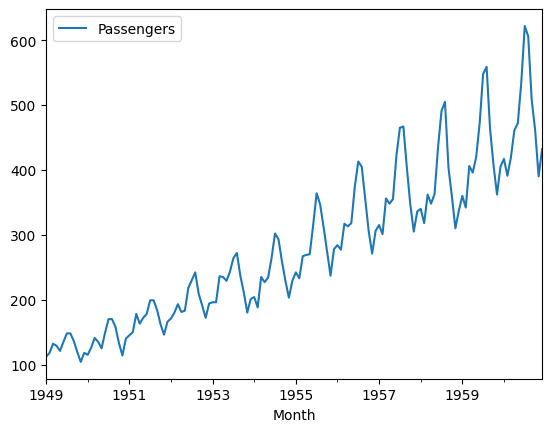

In [4]:
df.plot()

In [5]:
df['EWMA'] = df['Passengers'].ewm(alpha = 0.2 , adjust = False).mean()

<Axes: xlabel='Month'>

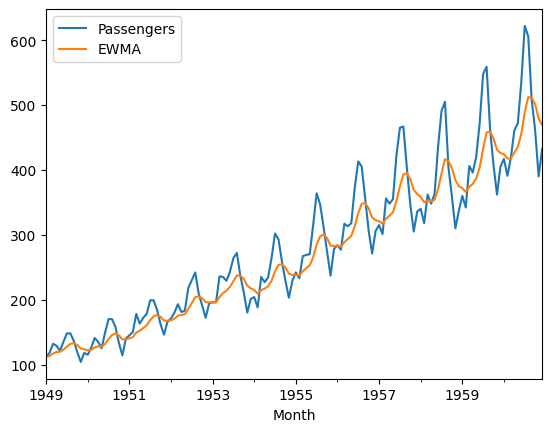

In [6]:
df.plot()

In [7]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0 :
        xhat = 0.2 * x + (1 - 0.2) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)    

df['Manual'] = manual_ewma

<Axes: xlabel='Month'>

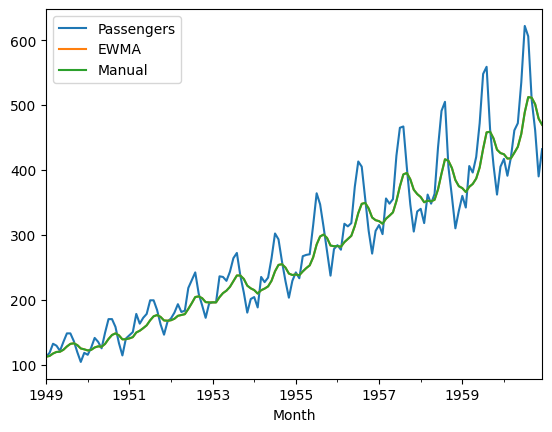

In [8]:
df.plot()

In [9]:
!pip install -U statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.1
    Uninstalling statsmodels-0.14.1:
      Successfully uninstalled statsmodels-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [11]:
ses = SimpleExpSmoothing(df['Passengers'])

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [13]:
df.index.freq = 'MS'

In [14]:
ses = SimpleExpSmoothing(
df['Passengers'],
initialization_method = 'legacy-heuristic')

In [15]:
results = ses.fit(smoothing_level = 0.2, optimized = False)

In [16]:
results

In [17]:
df['SES'] = results.predict(start= df.index[0], end = df.index[-1])

<Axes: xlabel='Month'>

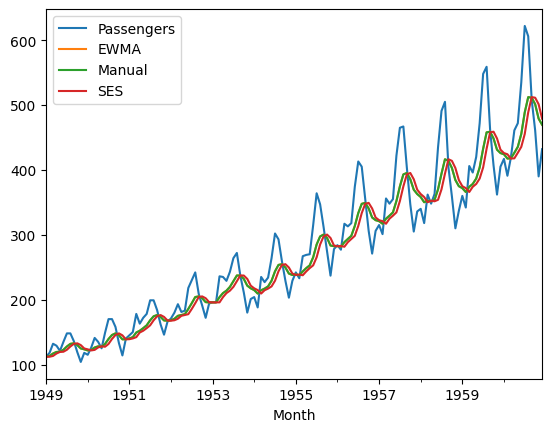

In [18]:
df.plot()

In [19]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [20]:
train.size

528

In [21]:
test.size

48

In [22]:
df.size

576

In [23]:
ses = SimpleExpSmoothing(
train['Passengers'],
initialization_method  = 'legacy-heuristic')

In [24]:
res = ses.fit()

In [25]:
train_idx = df.index <= train.index [-1]
test_idx = df.index > train.index[-1]

In [26]:
df.loc[train_idx, "SESfitted"] = res.fittedvalues
df.loc[test_idx, "SESfitted"] = res.forecast(N_test)

<Axes: xlabel='Month'>

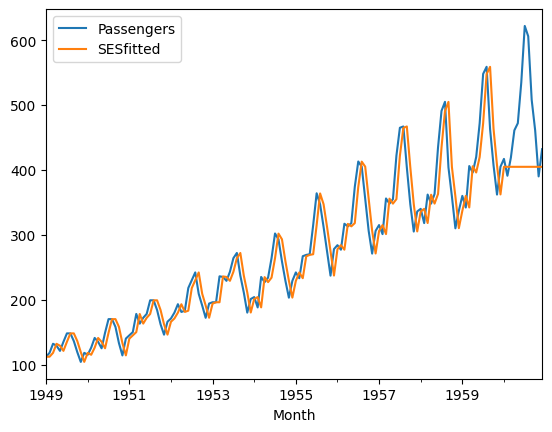

In [27]:
df[['Passengers','SESfitted']].plot()

In [28]:
## This will show us the optimized alpha value
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [29]:
from statsmodels.tsa.holtwinters import Holt

In [30]:
model = Holt(df['Passengers'],initialization_method = 'legacy-heuristic')

In [31]:
res = model.fit()

In [32]:
df['Holt'] = res.fittedvalues

<Axes: xlabel='Month'>

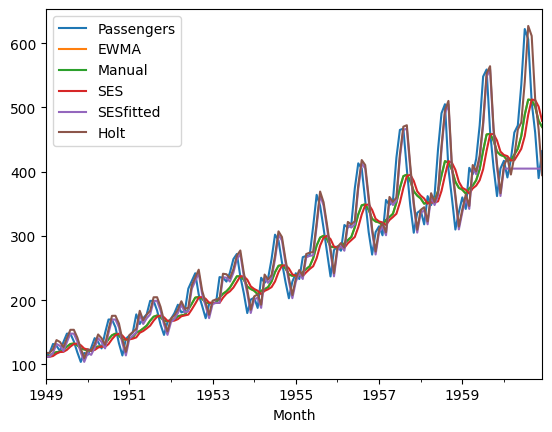

In [33]:
df.plot()

In [34]:
model_h = Holt(train['Passengers'], initialization_method = 'legacy-heuristic')

In [35]:
result_h = model_h.fit()

In [36]:
df.loc[train_idx,'Holt'] = result_h.fittedvalues

In [37]:
df.loc[test_idx,'Holt'] = result_h.forecast(N_test)

<Axes: xlabel='Month'>

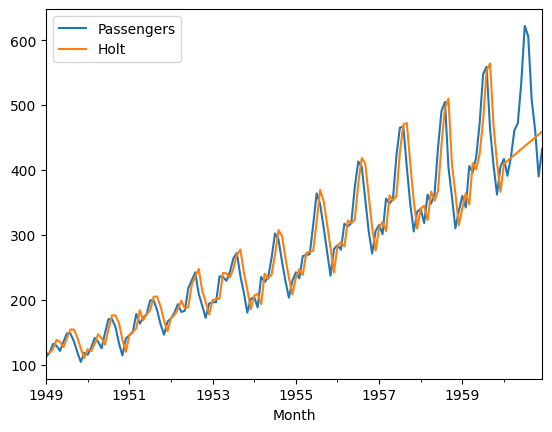

In [38]:
df[['Passengers','Holt']].plot()

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [40]:
hw = ExponentialSmoothing(train['Passengers'],
                         initialization_method = 'legacy-heuristic',
                         trend = 'add',seasonal='add',seasonal_periods=12)
res_hw = hw.fit()

In [41]:
df.loc[train_idx,'HoltWinters'] = res_hw.fittedvalues

In [42]:
df.loc[test_idx,'HoltWinters'] = res_hw.forecast(N_test)

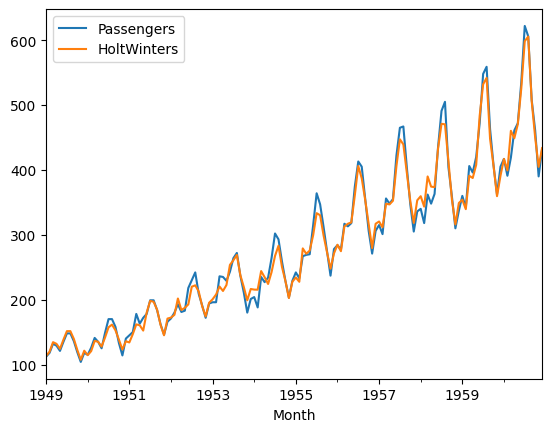

In [43]:
df[['Passengers','HoltWinters']].plot();

In [80]:
print(sqrt(mean_squared_error(train['Passengers'],res_hw.fittedvalues)))
print(sqrt(mean_squared_error(test['Passengers'],res_hw.forecast(N_test))))

11.853000976828765
15.543003084126884


In [46]:
hw_mul = ExponentialSmoothing(train['Passengers'],
                             initialization_method = 'legacy-heuristic',
                             trend= 'mul',seasonal = 'add',seasonal_periods=12)

In [47]:
res_hw_mul = hw_mul.fit()

In [48]:
df.loc[train_idx,'HoltWinters'] = res_hw_mul.fittedvalues

In [49]:
df.loc[test_idx,'HoltWinters'] = res_hw_mul.forecast(N_test)

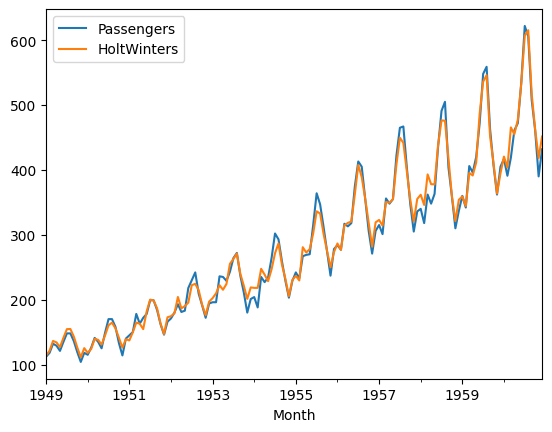

In [50]:
df[['Passengers','HoltWinters']].plot();

In [79]:
print(sqrt(mean_squared_error(train['Passengers'],res_hw_mul.fittedvalues)))
print(sqrt(mean_squared_error(test['Passengers'],res_hw_mul.forecast(N_test))))

11.64949055987474
18.212370236823283


In [51]:
hw_mul_mul = ExponentialSmoothing(train['Passengers'],
                                 initialization_method='legacy-heuristic',
                                 trend='mul',seasonal = 'mul',seasonal_periods=12)

In [53]:
res_mul_mul = hw_mul_mul.fit()

In [56]:
df.loc[train_idx,'HoltWinters'] = res_mul_mul.fittedvalues

In [57]:
df.loc[test_idx,'HoltWinters'] = res_mul_mul.forecast(N_test)

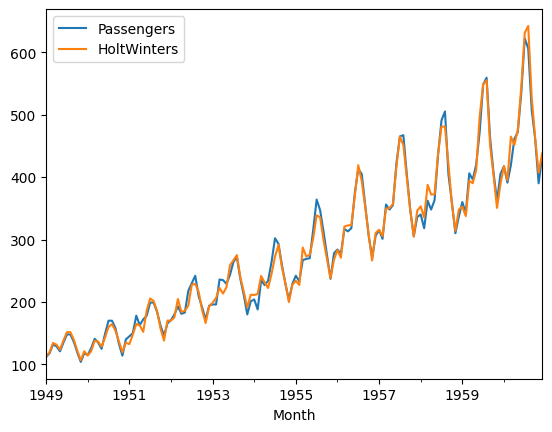

In [58]:
df[['Passengers','HoltWinters']].plot();

In [75]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [78]:
print(sqrt(mean_squared_error(train['Passengers'],res_mul_mul.fittedvalues)))
print(sqrt(mean_squared_error(test['Passengers'],res_mul_mul.forecast(N_test))))


9.887178133858725
19.102067803628128
